# **TRABAJO PRÁCTICO: Machine Learning**
- Alumno: Batallan David Leonardo
- Padrón: 97529
- mail: dbatallan@fi.uba.ar

# **Baseline**

Deberan construir un modelo muy sencillo para saber qué es lo peor que podemos hacer. En general, esta es una tarea muy importante que queremos que repitan en sus proyectos de machine learning. ¿Por qué?

Navaja de Ockam * : “Cuando se ofrecen dos o más explicaciones de un fenómeno, es preferible la explicación completa más simple; es decir, no deben multiplicarse las entidades sin necesidad.” ¿Para qué desarrollar un modelo super complejo si capaz es peor o casi igual que uno muy sencillo?
Nos sirve para saber si estamos usando bien los modelos más complejos, si su score nos da peor al baseline probablemente se deba a un error de código.
Nos sirve para rápidamente saber que tan complejo es un problema.
Los modelos simples son fáciles de entender.

Tareas a realizar

Utilizando todos las columnas del dataset (exceptuando ids únicos) con algún encoding donde sea necesario, entrenar una regresión logística, haciendo búsqueda de hiperparametros y garantizando su reproducibilidad (los resultados del notebook no deberan variar segun la corrida).
Responder

- ¿Cómo conviene obtener el dataset para validar?
- ¿Cuál es el mejor score de validación obtenido?
- ¿Qué features son los más importantes para predecir con el mejor modelo?
- Graficar el feature importance

Modelos para prediccion
Tareas a realizar

Para este punto debe diseñar y entrenar 2 modelos distintos a eleccion. Cada uno debe incluir su respectiva búsqueda de hiperparametros y feature engineering.
Requerimientos

Los modelos entre si deben ser de distintos tipos excluyendo regresiones logísticas.
Utilizar AUC-ROC como métrica de validación.
Deben medirse en validación.
Deben ser reproducibles (el resultado del notebook siempre debe ser el mismo).
Tener un score en validación superior a 0,8.
Para el feature engineering debe utilizarse al menos una vez:
        Imputación de nulos
        Mean encoding
        One hot encoding
Utilizar al menos 80 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
Utilizar las columnas: id_31, id_33, DeviceType, DeviceInfo.
Utilizar CountVectorizer o TfIdfVectorizer para algún feature.
Ambos modelos deben cumplir TODOS los requerimientos

Responder

- ¿Cómo conviene elegir los datos de validación respecto de los de train?.
- ¿Cuál de los dos modelos arroja mejores resultados?
- ¿Por que cree que se dio ese resultado?


In [5]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from category_encoders import BinaryEncoder

In [6]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

ModuleNotFoundError: No module named 'google.colab'

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
from datetime import datetime

In [9]:
pd.set_option('display.max_columns', None)

# **FUNCIONES DE MAPEO**

In [12]:
def map_timestamp_to_date(timestamp):

    return datetime.fromtimestamp(timestamp+pd.Timestamp('2024-01-01').timestamp()).date()

In [14]:
def map_timestamp_to_year(timestamp):

    return datetime.fromtimestamp(timestamp+pd.Timestamp('2024-01-01').timestamp()).year

In [16]:
def map_timestamp_to_month(timestamp):

    return datetime.fromtimestamp(timestamp+pd.Timestamp('2024-01-01').timestamp()).month

In [18]:
def map_timestamp_to_day(timestamp):

    return datetime.fromtimestamp(timestamp+pd.Timestamp('2024-01-01').timestamp()).day

In [20]:
def map_timestamp_to_hour(timestamp):

    return datetime.fromtimestamp(timestamp+pd.Timestamp('2024-01-01').timestamp()).hour

In [22]:
def map_timestamp_to_ndays(timestamp):

    return int((timestamp/(24*60*60))-1)

In [24]:
def map_nday_to_week_day(nday):

    return int(((nday-2) % 7)+1)

# **DATOS transactions_train.csv**

In [13]:
# transacciones_train.csv en https://drive.google.com/file/d/127v-fngGHW5IkzoYg7TL7KhVyZrTR3hN/view?usp=drive_link

id='127v-fngGHW5IkzoYg7TL7KhVyZrTR3hN'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('transactions_train.csv')

In [27]:
transactions_train = pd.read_csv('transactions_train.csv')
transactions_train = transactions_train.drop('Unnamed: 0', axis=1)

In [29]:
transactions_train.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,C1,C2,C3,C4,C5,C6,C7,C8,C9,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D222,D223,D224,D225,D226,D227,D228,D229,D230,D231,D232,D233,D234,D235,D236,D237,D238,D239,D240,D241,D242,D243,D244,D245,D246,D247,D248,D249,D250,D251,D252,D253,D254,D255,D256,D257,D258,D259,D260,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300,D301,D302,D303,D304,D305,D306,D307,D308,D309,D310,D311,D312,D313,D314,D315,D316,D317,D318,D319,D320,D321,D322,D323,D324,D325,D326,D327,D328,D329,D330,D331,D332,D333,D334,D335,D336,D337,D338,D339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0

In [31]:
pd.set_option('display.max_rows', None)  # Para mostrar todas las filas
pd.set_option('display.max_columns', None)  # Para mostrar todas las columnas
transactions_train.count()

Id                       501959
target                   501959
timestamp                501959
ammount                  501959
product_category         501959
feat_card_1              501959
feat_card_2              494639
feat_card_3              501136
feat_card_4              501126
feat_card_5              498706
feat_card_6              501131
addr1                    445541
addr2                    445541
dist1                    198630
dist2                     33283
payer_email_domain       423533
receiver_email_domain    118773
A1                       501959
A2                       501959
A3                       501959
A4                       501959
A5                       501959
A6                       501959
A7                       501959
A8                       501959
A9                       501959
A10                      501959
A11                      501959
A12                      501959
A13                      501959
A14                      501959
B1      

# **DATOS identity_features_train.csv**

In [31]:
# identity_features_train.csv en https://drive.google.com/file/d/1u0sbL4T5wy6eag2aZclxexOxq9C3VblZ/view?usp=drive_link

id='1u0sbL4T5wy6eag2aZclxexOxq9C3VblZ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('identity_features_train.csv')

In [34]:
identity_features_train=pd.read_csv('identity_features_train.csv')

In [38]:
identity_features_train.head(2)

,Unnamed: 0,Id,feature01,feature02,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,Device,DeviceMetadata
0,0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


# **DATOS X_transactions_test.csv**

In [34]:
# X_transactions_test.csv en https://drive.google.com/file/d/1-34YJnGZC7rASSfKNSAqGtCg2bQRXZ0o/view?usp=drive_link

id='1-34YJnGZC7rASSfKNSAqGtCg2bQRXZ0o'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('X_transactions_test.csv')

In [42]:
X_transactions_test=pd.read_csv('X_transactions_test.csv')

In [43]:
X_transactions_test.head(2)

,Id,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,C1,C2,C3,C4,C5,C6,C7,C8,C9,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D222,D223,D224,D225,D226,D227,D228,D229,D230,D231,D232,D233,D234,D235,D236,D237,D238,D239,D240,D241,D242,D243,D244,D245,D246,D247,D248,D249,D250,D251,D252,D253,D254,D255,D256,D257,D258,D259,D260,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300,D301,D302,D303,D304,D305,D306,D307,D308,D309,D310,D311,D312,D313,D314,D315,D316,D317,D318,D319,D320,D321,D322,D323,D324,D325,D326,D327,D328,D329,D330,D331,D332,D333,D334,D335,D336,D337,D338,D339
0,3488959,13151880,57.95,W,7919,194.0,150.0,mastercard,166.0,debit,143.0,87.0,NaN,NaN,anonymous.com,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,31.0,NaN,NaN,NaN,NaN,332.0,0.0,NaN,NaN,NaN,365.0,T,T,F,NaN,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3488960,13151945,47.95,W,1764,158.0,150.0,visa,226.0,debit,315.0,87.0,18.0,NaN,gmail.com,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,57.0,NaN,NaN,NaN,NaN,57.0,358.0,NaN,NaN,NaN,428.0,T,T,T,NaN,NaN,F,F,T,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0

# **DATOS identity_features_test.csv**

In [37]:
# identity_features_test.csv en https://drive.google.com/file/d/1p9Am_R7nUeMwoxUf9hq7zjw3pdTmoKpv/view?usp=drive_link

id='1p9Am_R7nUeMwoxUf9hq7zjw3pdTmoKpv'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('identity_features_test.csv')

In [48]:
identity_features_test=pd.read_csv('identity_features_test.csv')

In [50]:
identity_features_test.head(2)

,Unnamed: 0,Id,feature01,feature02,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,Device,DeviceMetadata
0,125565,3488965,-25.0,804857.0,NaN,NaN,-8.0,-34.0,NaN,NaN,NaN,NaN,100.0,NotFound,64.0,NaN,New,NotFound,225.0,13.0,266.0,595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,other,NaN,NaN,NaN,F,F,T,F,mobile,Android 4.4.2
1,125566,3488967,-45.0,196445.0,0.0,0.0,1.0,-6.0,NaN,NaN,0.0,0.0,100.0,NotFound,64.0,NaN,Found,Found,225.0,NaN,153.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome generic,NaN,NaN,NaN,F,F,T,F,desktop,ALE-L23 Build/HuaweiALE-L23


# **MERGE DEL TRAIN**

In [54]:
transactions_train = transactions_train.iloc[:, :35]
transactions_train.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0


In [56]:
transactions_train.Id.count()

501959

In [58]:
identity_features_train = identity_features_train[['Id', 'feature31', 'feature33', 'Device', 'DeviceMetadata']]
identity_features_train['feature31'] = identity_features_train['feature31'].fillna('N/A')
identity_features_train['feature33'] = identity_features_train['feature33'].fillna('N/A')
identity_features_train['Device'] = identity_features_train['Device'].fillna('N/A')
identity_features_train['DeviceMetadata'] = identity_features_train['DeviceMetadata'].fillna('N/A')
identity_features_train.head(2)

,Id,feature31,feature33,Device,DeviceMetadata
0,2987004,samsung browser 6.2,2220x1080,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,mobile safari 11.0,1334x750,mobile,iOS Device


In [63]:
transactions_train = transactions_train.merge(identity_features_train, on='Id', how='left')

In [65]:
transactions_train.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [67]:
transactions_train.Id.count()

501959

# **MERGE DEL TEST**

In [70]:
X_transactions_test = X_transactions_test.iloc[:, :34]
X_transactions_test.head(2)

,Id,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4
0,3488959,13151880,57.95,W,7919,194.0,150.0,mastercard,166.0,debit,143.0,87.0,NaN,NaN,anonymous.com,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0
1,3488960,13151945,47.95,W,1764,158.0,150.0,visa,226.0,debit,315.0,87.0,18.0,NaN,gmail.com,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0


In [72]:
identity_features_test = identity_features_test[['Id', 'feature31', 'feature33', 'Device', 'DeviceMetadata']]
identity_features_test['feature31'] = identity_features_test['feature31'].fillna('N/A')
identity_features_test['feature33'] = identity_features_test['feature33'].fillna('N/A')
identity_features_test['Device'] = identity_features_test['Device'].fillna('N/A')
identity_features_test['DeviceMetadata'] = identity_features_test['DeviceMetadata'].fillna('N/A')
identity_features_test.head(2)

,Id,feature31,feature33,Device,DeviceMetadata
0,3488965,other,N/A,mobile,Android 4.4.2
1,3488967,chrome generic,N/A,desktop,ALE-L23 Build/HuaweiALE-L23


In [74]:
X_transactions_test = X_transactions_test.merge(identity_features_test, on='Id', how='left')

In [76]:
X_transactions_test.head(2)

,Id,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata
0,3488959,13151880,57.95,W,7919,194.0,150.0,mastercard,166.0,debit,143.0,87.0,NaN,NaN,anonymous.com,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,NaN,NaN,NaN,NaN
1,3488960,13151945,47.95,W,1764,158.0,150.0,visa,226.0,debit,315.0,87.0,18.0,NaN,gmail.com,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,NaN,NaN,NaN,NaN


# **SEPARACION VALIDATION Y TRAIN**

In [79]:
transactions_train['hour']=transactions_train['timestamp'].map(map_timestamp_to_hour)
transactions_train['ndays']=transactions_train['timestamp'].map(map_timestamp_to_ndays)
transactions_train['ndays']=transactions_train['ndays']-transactions_train['ndays'].min()
transactions_train['week_day']=transactions_train['ndays'].map(map_nday_to_week_day)

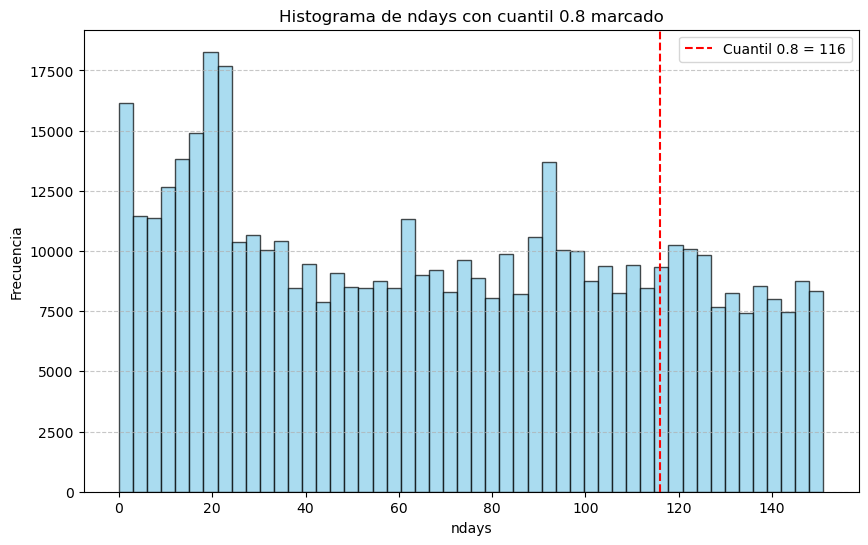

In [80]:
import matplotlib.pyplot as plt

# Calcular el cuantil 0.8
cutoff_day = transactions_train['ndays'].quantile(0.8)

# Crear el histograma de 'ndays'
plt.figure(figsize=(10, 6))
plt.hist(transactions_train['ndays'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(cutoff_day, color='red', linestyle='--', label=f'Cuantil 0.8 = {cutoff_day:.0f}')

# Añadir etiquetas y leyenda
plt.title('Histograma de ndays con cuantil 0.8 marcado')
plt.xlabel('ndays')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **Cambio float64 a float32 del train**

In [84]:
transactions_train.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,21,0,6
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,21,0,6


In [86]:
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501959 entries, 0 to 501958
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     501959 non-null  int64  
 1   target                 501959 non-null  int64  
 2   timestamp              501959 non-null  int64  
 3   ammount                501959 non-null  float64
 4   product_category       501959 non-null  object 
 5   feat_card_1            501959 non-null  int64  
 6   feat_card_2            494639 non-null  float64
 7   feat_card_3            501136 non-null  float64
 8   feat_card_4            501126 non-null  object 
 9   feat_card_5            498706 non-null  float64
 10  feat_card_6            501131 non-null  object 
 11  addr1                  445541 non-null  float64
 12  addr2                  445541 non-null  float64
 13  dist1                  198630 non-null  float64
 14  dist2                  33283 non-nul

In [88]:
float_cols = transactions_train.select_dtypes(include=['float64']).columns
transactions_train[float_cols] = transactions_train[float_cols].astype(np.float32)
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501959 entries, 0 to 501958
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     501959 non-null  int64  
 1   target                 501959 non-null  int64  
 2   timestamp              501959 non-null  int64  
 3   ammount                501959 non-null  float32
 4   product_category       501959 non-null  object 
 5   feat_card_1            501959 non-null  int64  
 6   feat_card_2            494639 non-null  float32
 7   feat_card_3            501136 non-null  float32
 8   feat_card_4            501126 non-null  object 
 9   feat_card_5            498706 non-null  float32
 10  feat_card_6            501131 non-null  object 
 11  addr1                  445541 non-null  float32
 12  addr2                  445541 non-null  float32
 13  dist1                  198630 non-null  float32
 14  dist2                  33283 non-nul

## **Cambio float64 a float32 del test**

In [91]:
X_transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88581 entries, 0 to 88580
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     88581 non-null  int64  
 1   timestamp              88581 non-null  int64  
 2   ammount                88581 non-null  float64
 3   product_category       88581 non-null  object 
 4   feat_card_1            88581 non-null  int64  
 5   feat_card_2            86968 non-null  float64
 6   feat_card_3            87839 non-null  float64
 7   feat_card_4            87837 non-null  object 
 8   feat_card_5            87575 non-null  float64
 9   feat_card_6            87838 non-null  object 
 10  addr1                  79293 non-null  float64
 11  addr2                  79293 non-null  float64
 12  dist1                  39639 non-null  float64
 13  dist2                  4344 non-null   float64
 14  payer_email_domain     72551 non-null  object 
 15  re

In [93]:
float_cols = X_transactions_test.select_dtypes(include=['float64']).columns
X_transactions_test[float_cols] = X_transactions_test[float_cols].astype(np.float32)
X_transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88581 entries, 0 to 88580
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     88581 non-null  int64  
 1   timestamp              88581 non-null  int64  
 2   ammount                88581 non-null  float32
 3   product_category       88581 non-null  object 
 4   feat_card_1            88581 non-null  int64  
 5   feat_card_2            86968 non-null  float32
 6   feat_card_3            87839 non-null  float32
 7   feat_card_4            87837 non-null  object 
 8   feat_card_5            87575 non-null  float32
 9   feat_card_6            87838 non-null  object 
 10  addr1                  79293 non-null  float32
 11  addr2                  79293 non-null  float32
 12  dist1                  39639 non-null  float32
 13  dist2                  4344 non-null   float32
 14  payer_email_domain     72551 non-null  object 
 15  re

## **Relleno de datos nulos**

In [97]:
transactions_train.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,21,0,6
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,21,0,6


In [99]:
transactions_train.target.value_counts()

target
0    484379
1     17580
Name: count, dtype: int64

In [101]:
484379/(484379+17580)

0.964977219254959

In [103]:
train_data = transactions_train[transactions_train['ndays'] <= cutoff_day]
valid_data = transactions_train[transactions_train['ndays'] > cutoff_day]

In [106]:
train_data.ndays.max()

116

In [108]:
valid_data.ndays.min()

117

In [110]:
train_data.target.value_counts()

target
0    389965
1     14157
Name: count, dtype: int64

In [112]:
389965/(389965+14157)

0.9649684996115034

In [114]:
valid_data.target.value_counts()

target
0    94414
1     3423
Name: count, dtype: int64

In [116]:
94414/(94414+3423)

0.9650132363011948

In [118]:
feat_card_columns = ['feat_card_1', 'feat_card_2', 'feat_card_3','feat_card_5','addr1','addr2','dist1','dist2','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','B1','B2','B3','B4']

# Rellenar cada columna con su media
for col in feat_card_columns:
    promedio=train_data[col].mean()
    print(promedio)
    train_data[col].fillna(promedio, inplace=True)
    valid_data[col].fillna(promedio, inplace=True)
    X_transactions_test[col].fillna(promedio, inplace=True)


9865.789872860176
363.7015
153.29701
199.78923
290.46326
86.76125
125.77678
241.00485
16.050623
17.576
0.0057160957
5.144617
5.2908406
10.00092
4.0031033
6.868223
4.2142744
7.0150747
11.640477
5.6716237
32.63176
8.814724
87.55178
165.31738
28.56118
131.24806


C:\Users\David\AppData\Local\Temp\ipykernel_12644\2249251442.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(promedio, inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_12644\2249251442.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col].fillna(promedio, inplace=True)
C:\Users\David\AppData\Lo

In [120]:
train_data.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day
0,2987000,0,86400,68.5,W,13926,363.701508,150.0,discover,142.0,credit,315.0,87.0,19.000000,241.004852,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6
1,2987001,0,86401,29.0,W,2755,404.000000,150.0,mastercard,102.0,credit,325.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6


In [122]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404122 entries, 0 to 404121
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     404122 non-null  int64  
 1   target                 404122 non-null  int64  
 2   timestamp              404122 non-null  int64  
 3   ammount                404122 non-null  float32
 4   product_category       404122 non-null  object 
 5   feat_card_1            404122 non-null  int64  
 6   feat_card_2            404122 non-null  float32
 7   feat_card_3            404122 non-null  float32
 8   feat_card_4            403293 non-null  object 
 9   feat_card_5            404122 non-null  float32
 10  feat_card_6            403296 non-null  object 
 11  addr1                  404122 non-null  float32
 12  addr2                  404122 non-null  float32
 13  dist1                  404122 non-null  float32
 14  dist2                  404122 non-null  f

# **FEATURE ENGINEERING**

In [125]:
train_data.count()

Id                       404122
target                   404122
timestamp                404122
ammount                  404122
product_category         404122
feat_card_1              404122
feat_card_2              404122
feat_card_3              404122
feat_card_4              403293
feat_card_5              404122
feat_card_6              403296
addr1                    404122
addr2                    404122
dist1                    404122
dist2                    404122
payer_email_domain       340957
receiver_email_domain    100732
A1                       404122
A2                       404122
A3                       404122
A4                       404122
A5                       404122
A6                       404122
A7                       404122
A8                       404122
A9                       404122
A10                      404122
A11                      404122
A12                      404122
A13                      404122
A14                      404122
B1      

In [127]:
valid_data.count()

Id                       97837
target                   97837
timestamp                97837
ammount                  97837
product_category         97837
feat_card_1              97837
feat_card_2              97837
feat_card_3              97837
feat_card_4              97833
feat_card_5              97837
feat_card_6              97835
addr1                    97837
addr2                    97837
dist1                    97837
dist2                    97837
payer_email_domain       82576
receiver_email_domain    18041
A1                       97837
A2                       97837
A3                       97837
A4                       97837
A5                       97837
A6                       97837
A7                       97837
A8                       97837
A9                       97837
A10                      97837
A11                      97837
A12                      97837
A13                      97837
A14                      97837
B1                       97837
B2      

In [129]:
X_transactions_test.count()

Id                       88581
timestamp                88581
ammount                  88581
product_category         88581
feat_card_1              88581
feat_card_2              88581
feat_card_3              88581
feat_card_4              87837
feat_card_5              88581
feat_card_6              87838
addr1                    88581
addr2                    88581
dist1                    88581
dist2                    88581
payer_email_domain       72551
receiver_email_domain    18518
A1                       88581
A2                       88581
A3                       88581
A4                       88581
A5                       88581
A6                       88581
A7                       88581
A8                       88581
A9                       88581
A10                      88581
A11                      88581
A12                      88581
A13                      88581
A14                      88581
B1                       88581
B2                       88581
B3      

## **ENCODEO PRODUCT_CATEGORY**

In [132]:
train_data.product_category.value_counts()

product_category
W    291001
C     48340
R     29816
H     27893
S      7072
Name: count, dtype: int64

In [134]:
train_data.product_category.value_counts()

product_category
W    291001
C     48340
R     29816
H     27893
S      7072
Name: count, dtype: int64

In [136]:
ohe_Embarked = OneHotEncoder()

encoded_emb = ohe_Embarked.fit_transform(train_data[['product_category']]).todense().astype(int)
encoded_emb_valid = ohe_Embarked.transform(valid_data[['product_category']]).todense().astype(int)
encoded_emb_test = ohe_Embarked.transform(X_transactions_test[['product_category']]).todense().astype(int)

In [138]:
column_names = ohe_Embarked.categories_[0]

In [140]:
column_names

array(['C', 'H', 'R', 'S', 'W'], dtype=object)

In [142]:
encoded_df = pd.DataFrame(encoded_emb, columns=column_names)
encoded_df_valid = pd.DataFrame(encoded_emb_valid, columns=column_names)
encoded_df_test = pd.DataFrame(encoded_emb_test, columns=column_names)

In [144]:
train_data.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day
0,2987000,0,86400,68.5,W,13926,363.701508,150.0,discover,142.0,credit,315.0,87.0,19.000000,241.004852,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6
1,2987001,0,86401,29.0,W,2755,404.000000,150.0,mastercard,102.0,credit,325.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6


In [146]:
valid_data.head(2)

,Id,target,timestamp,ammount,product_category,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day
404122,3391122,0,10195249,29.5,W,13010,555.0,150.0,visa,226.0,debit,203.0,87.0,125.776779,241.004852,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4
404123,3391123,0,10195254,97.0,W,11386,555.0,150.0,visa,226.0,debit,204.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4


In [149]:
train_data = train_data.reset_index().drop(['index', 'product_category'],axis=1).join(encoded_df)
valid_data = valid_data.reset_index().drop(['index', 'product_category'],axis=1).join(encoded_df_valid)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'product_category'],axis=1).join(encoded_df_test)

In [151]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W
0,2987000,0,86400,68.5,13926,363.701508,150.0,discover,142.0,credit,315.0,87.0,19.000000,241.004852,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,mastercard,102.0,credit,325.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1


In [153]:
valid_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W
0,3391122,0,10195249,29.5,13010,555.0,150.0,visa,226.0,debit,203.0,87.0,125.776779,241.004852,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1
1,3391123,0,10195254,97.0,11386,555.0,150.0,visa,226.0,debit,204.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1


In [155]:
X_transactions_test.head(2)

,Id,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_4,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,C,H,R,S,W
0,3488959,13151880,57.950001,7919,194.0,150.0,mastercard,166.0,debit,143.0,87.0,125.776779,241.004852,anonymous.com,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,NaN,NaN,NaN,NaN,0,0,0,0,1
1,3488960,13151945,47.950001,1764,158.0,150.0,visa,226.0,debit,315.0,87.0,18.000000,241.004852,gmail.com,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,NaN,NaN,NaN,NaN,0,0,0,0,1


## **FEAT_CARD_1**

## **ENCODEO FEAT_CARD_4**

In [161]:
train_data.feat_card_4.count()

403293

In [163]:
train_data.feat_card_4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [165]:
train_data.feat_card_6.unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [167]:
train_data['feat_card_4'] = train_data['feat_card_4'].fillna('FC4_S/D')
valid_data['feat_card_4'] = valid_data['feat_card_4'].fillna('FC4_S/D')
X_transactions_test['feat_card_4'] = X_transactions_test['feat_card_4'].fillna('FC4_S/D')


In [169]:
train_data.feat_card_4.unique()

array(['discover', 'mastercard', 'visa', 'american express', 'FC4_S/D'],
      dtype=object)

In [171]:
train_data.feat_card_4.value_counts()

feat_card_4
visa                264194
mastercard          127749
american express      6670
discover              4680
FC4_S/D                829
Name: count, dtype: int64

In [173]:
train_data.feat_card_4.count()

404122

Encodeo **feat_card_4**

In [177]:
encoded_emb_fc4 = ohe_Embarked.fit_transform(train_data[['feat_card_4']]).todense().astype(int)
encoded_emb_valid_fc4 = ohe_Embarked.transform(valid_data[['feat_card_4']]).todense().astype(int)
encoded_emb_test_fc4 = ohe_Embarked.transform(X_transactions_test[['feat_card_4']]).todense().astype(int)

In [179]:
column_names = ohe_Embarked.categories_[0]

In [181]:
column_names

array(['FC4_S/D', 'american express', 'discover', 'mastercard', 'visa'],
      dtype=object)

In [186]:
encoded_df_fc4 = pd.DataFrame(encoded_emb, columns=column_names)
encoded_df_valid_fc4 = pd.DataFrame(encoded_emb_valid_fc4, columns=column_names)
encoded_df_test_fc4 = pd.DataFrame(encoded_emb_test_fc4, columns=column_names)

In [188]:
train_data  = train_data .reset_index().drop(['index', 'feat_card_4'],axis=1).join(encoded_df_fc4)
valid_data = valid_data.reset_index().drop(['index', 'feat_card_4'],axis=1).join(encoded_df_valid_fc4)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'feat_card_4'],axis=1).join(encoded_df_test_fc4)

In [190]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,feat_card_6,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,credit,315.0,87.0,19.000000,241.004852,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,credit,325.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1


## **FEAT_CARD_6**

In [194]:
train_data.feat_card_6.value_counts()

feat_card_6
debit              295950
credit             107302
debit or credit        29
charge card            15
Name: count, dtype: int64

In [196]:
train_data.feat_card_6.unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [198]:
valid_data.feat_card_6.unique()

array(['debit', 'credit', 'debit or credit', nan], dtype=object)

In [200]:
X_transactions_test.feat_card_6.unique()

array(['debit', 'credit', nan], dtype=object)

In [202]:
train_data['feat_card_6'] = train_data['feat_card_6'].fillna('FC6_S/D')
valid_data['feat_card_6'] = valid_data['feat_card_6'].fillna('FC6_S/D')
X_transactions_test['feat_card_6'] = X_transactions_test['feat_card_6'].fillna('FC6_S/D')

In [204]:
encoded_emb_fc6 = ohe_Embarked.fit_transform(train_data[['feat_card_6']]).todense().astype(int)
encoded_emb_valid_fc6 = ohe_Embarked.transform(valid_data[['feat_card_6']]).todense().astype(int)
encoded_emb_test_fc6 = ohe_Embarked.transform(X_transactions_test[['feat_card_6']]).todense().astype(int)

In [206]:
column_names = ohe_Embarked.categories_[0]

In [208]:
column_names

array(['FC6_S/D', 'charge card', 'credit', 'debit', 'debit or credit'],
      dtype=object)

In [210]:
encoded_df_fc6 = pd.DataFrame(encoded_emb, columns=column_names)
encoded_df_valid_fc6 = pd.DataFrame(encoded_emb_valid_fc6, columns=column_names)
encoded_df_test_fc6 = pd.DataFrame(encoded_emb_test_fc6, columns=column_names)

In [212]:
train_data  = train_data .reset_index().drop(['index', 'feat_card_6'],axis=1).join(encoded_df_fc6)
valid_data = valid_data.reset_index().drop(['index', 'feat_card_6'],axis=1).join(encoded_df_valid_fc6)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'feat_card_6'],axis=1).join(encoded_df_test_fc6)

In [214]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,payer_email_domain,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


## **ECONDEO payer_email_domain**

In [220]:
train_data.payer_email_domain.unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [222]:
train_data['payer_email_domain'] = train_data['payer_email_domain'].fillna('PED_S/D')
valid_data['payer_email_domain'] = valid_data['payer_email_domain'].fillna('PED_S/D')
X_transactions_test['payer_email_domain'] = X_transactions_test['payer_email_domain'].fillna('PED_S/D')

In [224]:
binary_encoder_ped = BinaryEncoder(cols=['payer_email_domain'])
encoded_train_data_ped = binary_encoder_ped.fit_transform(train_data[['payer_email_domain']])
encoded_valid_data_ped = binary_encoder_ped.transform(valid_data[['payer_email_domain']])
encoded_test_data_ped = binary_encoder_ped.transform(X_transactions_test[['payer_email_domain']])

In [226]:
train_data = train_data.reset_index().drop(['index', 'payer_email_domain'], axis=1).join(encoded_train_data_ped)
valid_data = valid_data.reset_index().drop(['index', 'payer_email_domain'], axis=1).join(encoded_valid_data_ped)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'payer_email_domain'], axis=1).join(encoded_test_data_ped)

In [229]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [231]:
valid_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5
0,3391122,0,10195249,29.5,13010,555.0,150.0,226.0,203.0,87.0,125.776779,241.004852,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,3391123,0,10195254,97.0,11386,555.0,150.0,226.0,204.0,87.0,125.776779,241.004852,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [233]:
X_transactions_test.head(2)

,Id,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,receiver_email_domain,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5
0,3488959,13151880,57.950001,7919,194.0,150.0,166.0,143.0,87.0,125.776779,241.004852,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
1,3488960,13151945,47.950001,1764,158.0,150.0,226.0,315.0,87.0,18.000000,241.004852,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


## **ECONDEO receiver_email_domain**

In [237]:
train_data.receiver_email_domain.unique()

array([nan, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com',
       'charter.net', 'prodigy.net.mx', 'comcast.net', 'live.com.mx',
       'icloud.com', 'yahoo.com', 'aol.com', 'juno.com', 'att.net',
       'verizon.net', 'yahoo.com.mx', 'bellsouth.net', 'servicios-ta.com',
       'ymail.com', 'hotmail.es', 'msn.com', 'optonline.net', 'live.com',
       'gmx.de', 'aim.com', 'mail.com', 'me.com', 'outlook.es', 'cox.net',
       'earthlink.net', 'embarqmail.com', 'web.de', 'sbcglobal.net',
       'scranton.edu', 'mac.com', 'twc.com', 'roadrunner.com', 'yahoo.fr',
       'yahoo.de', 'yahoo.es', 'frontiernet.net', 'gmail', 'live.fr',
       'q.com', 'yahoo.co.uk', 'windstream.net', 'suddenlink.net',
       'hotmail.fr', 'ptd.net', 'hotmail.de', 'frontier.com',
       'cfl.rr.com', 'hotmail.co.uk', 'netzero.com', 'netzero.net',
       'yahoo.co.jp', 'rocketmail.com', 'centurylink.net',
       'protonmail.com', 'cableone.net', 'sc.rr.com'], dtype=object)

In [239]:
train_data['receiver_email_domain'] = train_data['receiver_email_domain'].fillna('RED_S/D')
valid_data['receiver_email_domain'] = valid_data['receiver_email_domain'].fillna('RED_S/D')
X_transactions_test['receiver_email_domain'] = X_transactions_test['receiver_email_domain'].fillna('RED_S/D')

In [241]:
binary_encoder_ped = BinaryEncoder(cols=['receiver_email_domain'])
encoded_train_data_red = binary_encoder_ped.fit_transform(train_data[['receiver_email_domain']])
encoded_valid_data_red = binary_encoder_ped.transform(valid_data[['receiver_email_domain']])
encoded_test_data_red = binary_encoder_ped.transform(X_transactions_test[['receiver_email_domain']])

In [243]:
train_data = train_data.reset_index().drop(['index', 'receiver_email_domain'], axis=1).join(encoded_train_data_red)
valid_data = valid_data.reset_index().drop(['index', 'receiver_email_domain'], axis=1).join(encoded_valid_data_red)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'receiver_email_domain'], axis=1).join(encoded_test_data_red)

In [245]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [247]:
valid_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5
0,3391122,0,10195249,29.5,13010,555.0,150.0,226.0,203.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,3391123,0,10195254,97.0,11386,555.0,150.0,226.0,204.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,NaN,NaN,NaN,NaN,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [249]:
X_transactions_test.head(2)

,Id,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,feature31,feature33,Device,DeviceMetadata,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5
0,3488959,13151880,57.950001,7919,194.0,150.0,166.0,143.0,87.0,125.776779,241.004852,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1
1,3488960,13151945,47.950001,1764,158.0,150.0,226.0,315.0,87.0,18.000000,241.004852,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


## **ENCODEO feature31**

In [319]:
train_data.feature31.unique()

array(['FEAT_31_S/D', 'samsung browser 6.2', 'mobile safari 11.0',
       'chrome 62.0', 'N/A', 'chrome 62.0 for android', 'edge 15.0',
       'mobile safari generic', 'chrome 49.0', 'chrome 61.0', 'edge 16.0',
       'safari generic', 'edge 14.0', 'chrome 56.0 for android',
       'firefox 57.0', 'chrome 54.0 for android',
       'mobile safari uiwebview', 'chrome', 'chrome 62.0 for ios',
       'firefox', 'chrome 60.0 for android', 'mobile safari 10.0',
       'chrome 61.0 for android', 'ie 11.0 for desktop',
       'ie 11.0 for tablet', 'mobile safari 9.0', 'chrome generic',
       'other', 'chrome 59.0 for android', 'firefox 56.0',
       'android webview 4.0', 'chrome 55.0', 'opera 49.0', 'ie',
       'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       '

In [258]:
train_data['feature31'] = train_data['feature31'].fillna('FEAT_31_S/D')
valid_data['feature31'] = valid_data['feature31'].fillna('FEAT_31_S/D')
X_transactions_test['feature31'] = X_transactions_test['feature31'].fillna('FEAT_31_S/D')

In [260]:
train_data.feature31.unique()

array(['FEAT_31_S/D', 'samsung browser 6.2', 'mobile safari 11.0',
       'chrome 62.0', 'N/A', 'chrome 62.0 for android', 'edge 15.0',
       'mobile safari generic', 'chrome 49.0', 'chrome 61.0', 'edge 16.0',
       'safari generic', 'edge 14.0', 'chrome 56.0 for android',
       'firefox 57.0', 'chrome 54.0 for android',
       'mobile safari uiwebview', 'chrome', 'chrome 62.0 for ios',
       'firefox', 'chrome 60.0 for android', 'mobile safari 10.0',
       'chrome 61.0 for android', 'ie 11.0 for desktop',
       'ie 11.0 for tablet', 'mobile safari 9.0', 'chrome generic',
       'other', 'chrome 59.0 for android', 'firefox 56.0',
       'android webview 4.0', 'chrome 55.0', 'opera 49.0', 'ie',
       'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       '

In [262]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404122 entries, 0 to 404121
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       404122 non-null  int64  
 1   target                   404122 non-null  int64  
 2   timestamp                404122 non-null  int64  
 3   ammount                  404122 non-null  float32
 4   feat_card_1              404122 non-null  int64  
 5   feat_card_2              404122 non-null  float32
 6   feat_card_3              404122 non-null  float32
 7   feat_card_5              404122 non-null  float32
 8   addr1                    404122 non-null  float32
 9   addr2                    404122 non-null  float32
 10  dist1                    404122 non-null  float32
 11  dist2                    404122 non-null  float32
 12  A1                       404122 non-null  float32
 13  A2                       404122 non-null  float32
 14  A3  

In [254]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404122 entries, 0 to 404121
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       404122 non-null  int64  
 1   target                   404122 non-null  int64  
 2   timestamp                404122 non-null  int64  
 3   ammount                  404122 non-null  float32
 4   feat_card_1              404122 non-null  int64  
 5   feat_card_2              404122 non-null  float32
 6   feat_card_3              404122 non-null  float32
 7   feat_card_5              404122 non-null  float32
 8   addr1                    404122 non-null  float32
 9   addr2                    404122 non-null  float32
 10  dist1                    404122 non-null  float32
 11  dist2                    404122 non-null  float32
 12  A1                       404122 non-null  float32
 13  A2                       404122 non-null  float32
 14  A3  

In [296]:
vectorizer = CountVectorizer()
train_feature31_encoded = vectorizer.fit_transform(train_data['feature31'].astype(str))
valid_feature31_encoded = vectorizer.transform(valid_data['feature31'].astype(str))
test_feature31_encoded = vectorizer.transform(X_transactions_test['feature31'].astype(str))

In [309]:
train_feature31_encoded

<404122x79 sparse matrix of type '<class 'numpy.int64'>'
	with 571137 stored elements in Compressed Sparse Row format>

In [299]:
train_encoded_df = pd.DataFrame(train_feature31_encoded.toarray(), columns=vectorizer.get_feature_names_out())
valid_encoded_df = pd.DataFrame(valid_feature31_encoded.toarray(), columns=vectorizer.get_feature_names_out())
test_encoded_df = pd.DataFrame(test_feature31_encoded.toarray(), columns=vectorizer.get_feature_names_out())

In [311]:
train_encoded_df.head()

,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [305]:
train_data = pd.concat([train_data.reset_index(drop=True), train_encoded_df], axis=1)
valid_data = pd.concat([valid_data.reset_index(drop=True), valid_encoded_df], axis=1)
X_transactions_test = pd.concat([X_transactions_test.reset_index(drop=True), test_encoded_df], axis=1)

In [333]:
train_data.drop(columns=['feature31'], inplace=True)
valid_data.drop(columns=['feature31'], inplace=True)
X_transactions_test.drop(columns=['feature31'], inplace=True)

In [335]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## **ENCODEO feature33**

In [323]:
train_data.feature33.unique()

array([nan, '2220x1080', '1334x750', 'N/A', '1280x800', '1366x768',
       '1920x1080', '1680x1050', '1136x640', '5120x2880', '2880x1800',
       '1920x1200', '2560x1600', '2048x1536', '1024x768', '1280x720',
       '2560x1440', '2208x1242', '2001x1125', '1440x900', '1600x900',
       '2672x1440', '1280x1024', '960x540', '2732x2048', '2436x1125',
       '2048x1152', '2960x1440', '1024x600', '855x480', '4096x2304',
       '2160x1440', '2562x1442', '801x480', '2736x1824', '3441x1440',
       '2880x1620', '3840x2160', '1638x922', '1280x768', '1360x768',
       '1280x960', '3440x1440', '1152x720', '1280x1025', '3360x2100',
       '2304x1296', '1152x864', '3200x1800', '2112x1188', '2224x1668',
       '2400x1350', '2000x1125', '1600x1000', '2560x1080', '1728x972',
       '3000x2000', '1024x640', '3840x2400', '2304x1440', '1280x600',
       '1400x1050', '1600x1200', '3201x1800', '1356x900', '1344x756',
       '1624x1080', '1536x864', '1800x1125', '1920x1281', '2961x1442',
       '1366x1024', 

In [325]:
train_data['feature33'] = train_data['feature33'].fillna('FEAT_33_S/D')
valid_data['feature33'] = valid_data['feature33'].fillna('FEAT_33_S/D')
X_transactions_test['feature33'] = X_transactions_test['feature33'].fillna('FEAT_33_S/D')

In [327]:
binary_encoder_feat_33 = BinaryEncoder(cols=['feature33'])
encoded_train_data_feat_33 = binary_encoder_feat_33.fit_transform(train_data[['feature33']])
encoded_valid_data_feat_33 = binary_encoder_feat_33.transform(valid_data[['feature33']])
encoded_test_data_feat_33 = binary_encoder_feat_33.transform(X_transactions_test[['feature33']])

In [329]:
train_data = train_data.reset_index().drop(['index', 'feature33'], axis=1).join(encoded_train_data_feat_33)
valid_data = valid_data.reset_index().drop(['index', 'feature33'], axis=1).join(encoded_valid_data_feat_33)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'feature33'], axis=1).join(encoded_test_data_feat_33)

In [338]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,Device,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## **ENCODEO Device**

In [345]:
train_data.Device.unique()

array([nan, 'mobile', 'desktop', 'N/A'], dtype=object)

In [347]:
train_data['Device'] = train_data['Device'].fillna('Dev_S/D')
valid_data['Device'] = valid_data['Device'].fillna('Dev_S/D')
X_transactions_test['Device'] = X_transactions_test['Device'].fillna('Dev_S/D')

In [349]:
binary_encoder_device = BinaryEncoder(cols=['Device'])
encoded_train_data_device = binary_encoder_device.fit_transform(train_data[['Device']])
encoded_valid_data_device = binary_encoder_device.transform(valid_data[['Device']])
encoded_test_data_device = binary_encoder_device.transform(X_transactions_test[['Device']])

In [351]:
train_data = train_data.reset_index().drop(['index', 'Device'], axis=1).join(encoded_train_data_device)
valid_data = valid_data.reset_index().drop(['index', 'Device'], axis=1).join(encoded_valid_data_device)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'Device'], axis=1).join(encoded_test_data_device)

In [353]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,DeviceMetadata,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7,Device_0,Device_1,Device_2
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,NaN,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## **ENCODEO DeviceMetadata**

In [362]:
train_data.DeviceMetadata.unique()

array([nan, 'SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', ..., 'Star',
       'G8341', 'XT1580 Build/NPKS25.200-17-8'], dtype=object)

In [364]:
train_data['DeviceMetadata'] = train_data['DeviceMetadata'].fillna('Dev_Met_S/D')
valid_data['DeviceMetadata'] = valid_data['DeviceMetadata'].fillna('Dev_Met_S/D')
X_transactions_test['DeviceMetadata'] = X_transactions_test['DeviceMetadata'].fillna('Dev_Met_S/D')

In [370]:
binary_encoder_dev_met = BinaryEncoder(cols=['DeviceMetadata'])
encoded_train_data_dev_met = binary_encoder_dev_met.fit_transform(train_data[['DeviceMetadata']])
encoded_valid_data_dev_met = binary_encoder_dev_met.transform(valid_data[['DeviceMetadata']])
encoded_test_data_dev_met = binary_encoder_dev_met.transform(X_transactions_test[['DeviceMetadata']])

In [372]:
train_data = train_data.reset_index().drop(['index', 'DeviceMetadata'], axis=1).join(encoded_train_data_dev_met)
valid_data = valid_data.reset_index().drop(['index', 'DeviceMetadata'], axis=1).join(encoded_valid_data_dev_met)
X_transactions_test = X_transactions_test.reset_index().drop(['index', 'DeviceMetadata'], axis=1).join(encoded_test_data_dev_met)

In [374]:
train_data.head(2)

,Id,target,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7,Device_0,Device_1,Device_2,DeviceMetadata_0,DeviceMetadata_1,DeviceMetadata_2,DeviceMetadata_3,DeviceMetadata_4,DeviceMetadata_5,DeviceMetadata_6,DeviceMetadata_7,DeviceMetadata_8,DeviceMetadata_9,DeviceMetadata_10
0,2987000,0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


# **MODELOS DE PREDICCION**

In [390]:
train_data.info(161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404122 entries, 0 to 404121
Data columns (total 161 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    Id                       int64  
 1    target                   int64  
 2    timestamp                int64  
 3    ammount                  float32
 4    feat_card_1              int64  
 5    feat_card_2              float32
 6    feat_card_3              float32
 7    feat_card_5              float32
 8    addr1                    float32
 9    addr2                    float32
 10   dist1                    float32
 11   dist2                    float32
 12   A1                       float32
 13   A2                       float32
 14   A3                       float32
 15   A4                       float32
 16   A5                       float32
 17   A6                       float32
 18   A7                       float32
 19   A8                       float32
 20   A9                      

In [395]:
valid_data.info(161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97837 entries, 0 to 97836
Data columns (total 161 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    Id                       int64  
 1    target                   int64  
 2    timestamp                int64  
 3    ammount                  float32
 4    feat_card_1              int64  
 5    feat_card_2              float32
 6    feat_card_3              float32
 7    feat_card_5              float32
 8    addr1                    float32
 9    addr2                    float32
 10   dist1                    float32
 11   dist2                    float32
 12   A1                       float32
 13   A2                       float32
 14   A3                       float32
 15   A4                       float32
 16   A5                       float32
 17   A6                       float32
 18   A7                       float32
 19   A8                       float32
 20   A9                       f

In [397]:
X_transactions_test.info(161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88581 entries, 0 to 88580
Data columns (total 157 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    Id                       int64  
 1    timestamp                int64  
 2    ammount                  float32
 3    feat_card_1              int64  
 4    feat_card_2              float32
 5    feat_card_3              float32
 6    feat_card_5              float32
 7    addr1                    float32
 8    addr2                    float32
 9    dist1                    float32
 10   dist2                    float32
 11   A1                       float32
 12   A2                       float32
 13   A3                       float32
 14   A4                       float32
 15   A5                       float32
 16   A6                       float32
 17   A7                       float32
 18   A8                       float32
 19   A9                       float32
 20   A10                      f

In [414]:
x_train = train_data.drop(columns=['target','Id'])
y_train = train_data['target']

In [416]:
x_validation = valid_data.drop(columns=['target','Id'])
y_validation = valid_data['target']

In [418]:
x_train.head(2)

,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7,Device_0,Device_1,Device_2,DeviceMetadata_0,DeviceMetadata_1,DeviceMetadata_2,DeviceMetadata_3,DeviceMetadata_4,DeviceMetadata_5,DeviceMetadata_6,DeviceMetadata_7,DeviceMetadata_8,DeviceMetadata_9,DeviceMetadata_10
0,86400,68.5,13926,363.701508,150.0,142.0,315.0,87.0,19.000000,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,165.317383,13.00000,131.248062,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.000000,21,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [420]:
x_validation.head(2)

,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,hour,ndays,week_day,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7,Device_0,Device_1,Device_2,DeviceMetadata_0,DeviceMetadata_1,DeviceMetadata_2,DeviceMetadata_3,DeviceMetadata_4,DeviceMetadata_5,DeviceMetadata_6,DeviceMetadata_7,DeviceMetadata_8,DeviceMetadata_9,DeviceMetadata_10
0,10195249,29.5,13010,555.0,150.0,226.0,203.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,10195254,97.0,11386,555.0,150.0,226.0,204.0,87.0,125.776779,241.004852,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,165.317383,28.56118,0.0,21,117,4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [424]:
X_transactions_test.head(2)

,Id,timestamp,ammount,feat_card_1,feat_card_2,feat_card_3,feat_card_5,addr1,addr2,dist1,dist2,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,B1,B2,B3,B4,C,H,R,S,W,FC4_S/D,american express,discover,mastercard,visa,FC6_S/D,charge card,credit,debit,debit or credit,payer_email_domain_0,payer_email_domain_1,payer_email_domain_2,payer_email_domain_3,payer_email_domain_4,payer_email_domain_5,receiver_email_domain_0,receiver_email_domain_1,receiver_email_domain_2,receiver_email_domain_3,receiver_email_domain_4,receiver_email_domain_5,10,11,13,14,15,16,200,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,android,aol,blade,blu,browser,chrome,chromium,comodo,cyberfox,dash,desktop,edge,feat_31_s,firefox,for,g531h,g532m,generic,ie,ilium,inco,ios,iron,lanix,lg,line,lumia,m4,m4tel,maxthon,microsoft,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte,feature33_0,feature33_1,feature33_2,feature33_3,feature33_4,feature33_5,feature33_6,feature33_7,Device_0,Device_1,Device_2,DeviceMetadata_0,DeviceMetadata_1,DeviceMetadata_2,DeviceMetadata_3,DeviceMetadata_4,DeviceMetadata_5,DeviceMetadata_6,DeviceMetadata_7,DeviceMetadata_8,DeviceMetadata_9,DeviceMetadata_10
0,3488959,13151880,57.950001,7919,194.0,150.0,166.0,143.0,87.0,125.776779,241.004852,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,3488960,13151945,47.950001,1764,158.0,150.0,226.0,315.0,87.0,18.000000,241.004852,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: target, dtype: int64

# **Baseline**

In [430]:
model = XGBClassifier(gamma = 3.807233425619809,
                      max_depth= 8,
                      n_estimators= 220,
                      reg_alpha= 5,
                      reg_lambda= 0.06118423963716291, 
                      random_state = 42)
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.807233425619809, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [432]:
from sklearn.metrics import classification_report

In [434]:
print(classification_report(y_train, model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    389965
           1       0.93      0.51      0.66     14157

    accuracy                           0.98    404122
   macro avg       0.96      0.76      0.83    404122
weighted avg       0.98      0.98      0.98    404122



In [436]:
print(classification_report(y_validation, model.predict(x_validation)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     94414
           1       0.74      0.34      0.46      3423

    accuracy                           0.97     97837
   macro avg       0.86      0.67      0.73     97837
weighted avg       0.97      0.97      0.97     97837

